# danbooru tagger inference

In [1]:
from tagger import *

In [2]:
res_path = Path('results')

In [3]:
model = Tagger().to(dev)

state_dict = res_path / 'model_state_dict.pt'

model.load_state_dict(
    torch.load(state_dict, map_location=dev))

model.eval()

Tagger(
  (base): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, mo

In [4]:
all_labels = pd.read_csv(
    img_path, converters={'tags': eval}
).sort_values('id').reset_index(drop=True)

In [5]:
test_dir = Path().resolve().parent / 'data' / 'less-images' / 'test'
test_ids = sorted([int(f.stem) for f in test_dir.glob('*')])
test_labels = all_labels[all_labels.id.isin(test_ids)]
test_ds = DanbooruDataset(label_data=test_labels, img_dir=test_dir)

thresh_dl = DataLoader(get_random_sample(test_ds, round(len(test_ds)/10)))
test_dl = DataLoader(test_ds)

## defs

### inference

In [6]:
def get_y_true(y):
    y_arr = y[0].tolist()
    return set([
        i for i, prob in enumerate(y_arr) if round(prob)
    ])

In [7]:
def predict(X, thresh):
    
    res = pd.DataFrame(
                model(X).detach().numpy()
            ).T.squeeze(
            ).sort_values(
                ascending=False
            )
    
    return set(res[res>thresh].index)

In [8]:
def calc_metrics(y_true, y_pred, conf=False):
    
    tp = len(y_true.intersection(y_pred))
    fp = len(y_pred.difference(y_true))
    fn = len(y_true.difference(y_pred))

    try:
        prec = tp/(tp+fp)
        re = tp/(tp+fn)
        f1 = 2*re*prec/(re+prec)
    except ZeroDivisionError:
        prec = re = f1 = 0
    
    if conf:
        cm = np.array([[tp, fp],
                       [fn, 0]])
        
        
        mets = pd.DataFrame({
            'precision':[prec],
            'recall':[re],
            'f_score':[f1]
        })
        
        return {'conf':cm, 'met':mets}
    
    return np.array([prec, re, f1])

### plotting

In [9]:
def plot_losses(loss_df):
    return alt.Chart(
        loss_df.reset_index(
        ).rename(
            columns={'index': 'epoch'},
        ).melt(
            id_vars=['epoch'],
            value_vars=['train', 'val'],
            var_name='stage',
            value_name='MSE loss'
        )
    ).mark_line(
    ).encode(
        x=alt.X('epoch:Q', scale=alt.Scale(nice=False)),
        y=alt.Y('MSE loss:Q', scale=alt.Scale(zero=False)),
        color=alt.Color(
            'stage',
            scale=alt.Scale(
                scheme='darkgold'
            )
        )
    ).properties(
        width=300,
        height=250
    )

In [10]:
def plot_thresholds(res):
    base = alt.Chart(
        res.melt(
            id_vars=['threshold'],
            value_vars=[
                'precision',
                'recall',
                'f_score'
            ],
            var_name='metric',
            value_name='score'
        )
    ).encode(
        x=alt.X(
            'threshold:Q',
            axis=alt.Axis(format='%'),
            scale=alt.Scale(domain=(.2,.95), nice=False)
        ),
        y=alt.Y('score:Q', axis=alt.Axis(format='%')),
        color=alt.Color(
            'metric',
            scale=alt.Scale(
                scheme='darkgreen',
                reverse=True
            )
        )
    ).properties(
        height=300, width = 600
    )
    
    return base.mark_line() + base.mark_point()    

In [11]:
def plot_conf_matrix(conf, metrics):

    mm = metrics.mean()
    title = '  |  '.join([
        f'{mm.index[i]}: {mm.iloc[i]:.1%}'
        for i in range(len(mm))])

    conf_df = pd.DataFrame(
        conf, columns=['pos', 'neg'],
        index=pd.Index(['pos', 'neg'], name='pred')
    ).reset_index(
    ).melt(
        id_vars='pred',
        var_name='act',
        value_name='tot'
    )

    base = alt.Chart(
        conf_df, title=title
    ).encode(
        x=alt.X('pred:N', scale=alt.Scale(reverse=True)),
        y=alt.Y('act:N', scale=alt.Scale(reverse=True))
    ).properties(
        height=300, width=300
    )

    heatmap = base.mark_rect(
    ).encode(
        color=alt.Color(
            'tot:Q', legend=None,
            scale=alt.Scale(scheme='blues')
        )
    )

    cond = int(conf_df.tot.sum()/4)

    text = base.mark_text(
        baseline='middle', size=25
    ).encode(
        text='tot:Q',
        color=alt.condition(
            f'datum.tot < {cond}',
             alt.value('navy'),
             alt.value('azure')
        )
    )

    return heatmap+text

## training overview

In [12]:
loss_df = pd.read_csv(res_path / 'losses.csv')#.iloc[5:]
loss_df.train.min(), loss_df.val.min()

(0.0944140070862423, 0.0970204976036061)

In [13]:
plot_losses(
    loss_df.iloc[:50]
) | plot_losses(
    loss_df.iloc[50:]
)

alt.HConcatChart(...)

## metrics per threshold

calculated for a tenth of the dataset

In [14]:
arr = []

for thr in np.arange(.2, 1, .05):

    met = np.mean([
        calc_metrics(
            get_y_true(labels),
            predict(img, thr)
        ) for img, labels in thresh_dl
    ], axis=0)

    arr.append(np.insert(met, 0, round(thr,2)))
    
res = pd.DataFrame(
    arr, columns=['threshold', 'precision', 'recall', 'f_score'])

In [15]:
plot_thresholds(res)

alt.LayerChart(...)

In [16]:
thresh = .35

## confusion matrix

In [17]:
conf = np.zeros((2,2))
metrics = pd.DataFrame(
    columns=['precision', 'recall', 'f_score'])

for idx, (img, labels) in enumerate(test_dl):

    print(f'calculating metrics for sample #{idx}...', end=' ')
    
    y_true = get_y_true(labels)
    y_pred = predict(img, thresh)

    calc = calc_metrics(y_true, y_pred, True)
    
    conf += calc['conf']
    metrics = pd.concat([metrics, calc['met']])

    print('done!')

calculating metrics for sample #0... done!
calculating metrics for sample #1... done!
calculating metrics for sample #2... done!
calculating metrics for sample #3... done!
calculating metrics for sample #4... done!
calculating metrics for sample #5... done!
calculating metrics for sample #6... done!
calculating metrics for sample #7... done!
calculating metrics for sample #8... done!
calculating metrics for sample #9... done!
calculating metrics for sample #10... done!
calculating metrics for sample #11... done!
calculating metrics for sample #12... done!
calculating metrics for sample #13... done!
calculating metrics for sample #14... done!
calculating metrics for sample #15... done!
calculating metrics for sample #16... done!
calculating metrics for sample #17... done!
calculating metrics for sample #18... done!
calculating metrics for sample #19... done!
calculating metrics for sample #20... done!
calculating metrics for sample #21... done!
calculating metrics for sample #22... done

In [18]:
plot_conf_matrix(conf, metrics)

alt.LayerChart(...)

## inference examples

In [19]:
def show_image(img):
    
    inv = T.Compose([
        T.Normalize(
            mean=[0., 0., 0.],
            std=[1/0.229, 1/0.224, 1/0.225]
        ),
        T.Normalize(
            mean=[-0.485, -0.456, -0.406],
            std=[1., 1., 1.]
        ),
        T.ToPILImage(mode='RGB'),
    ])

    display(inv(img))
    return

In [20]:
def proba2lbls(proba, thresh):
    conv = pd.DataFrame(
        label_converter
    ).assign(
        proba=pd.Series(proba),
    ).sort_values(
        'proba', ascending=False
    ).set_index('tag')
    
    res = conv[conv.proba>thresh].copy()
    
    res.proba = res.proba.apply(lambda num: f'{num:.1%}')
    
    return res

In [21]:
samp_imgs = [2666009, 3339089, 3663128, 3860011, 4222081]
samp_inds = [idx for idx, img in enumerate(test_ids) if img in samp_imgs]
samp_dl = DataLoader(Subset((test_ds), samp_inds))

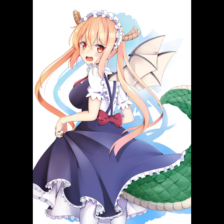

actual tags:
['long_hair', 'blonde_hair', 'twintails', 'hair_between_eyes', 'medium_breasts', 'looking_at_viewer', 'very_long_hair', 'shirt', 'bow', 'gloves', 'large_breasts', 'red_eyes', 'standing', 'skirt', 'eyebrows_visible_through_hair', 'smile', 'cowboy_shot', 'open_mouth', 'dress']


predicted tags with probability above 35%:


,proba
tag,
long_hair,100.0%
smile,46.5%
looking_at_viewer,46.3%
blush,46.2%
bangs,45.7%
simple_background,42.8%
eyebrows_visible_through_hair,42.3%
dress,41.2%
open_mouth,40.5%


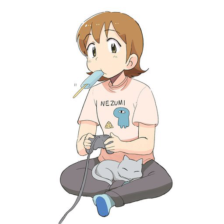

actual tags:
['brown_eyes', 'full_body', 'brown_hair', 'blush', 'short_hair', 'holding', 'looking_at_viewer', 'sitting', 'simple_background', 'closed_mouth', 'white_background', 'eyebrows_visible_through_hair', 'shirt']


predicted tags with probability above 35%:


,proba
tag,
blush,50.0%
bangs,49.0%
looking_at_viewer,49.0%
simple_background,48.6%
eyebrows_visible_through_hair,48.5%
smile,45.5%
long_hair,45.3%
blue_eyes,44.2%
white_background,41.1%


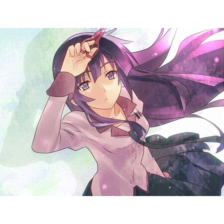

actual tags:
['long_hair', 'long_sleeves', 'purple_eyes', 'upper_body', 'collarbone', 'school_uniform', 'hair_between_eyes', 'medium_breasts', 'holding', 'looking_at_viewer', 'shirt', 'pleated_skirt', 'skirt', 'bangs', 'eyebrows_visible_through_hair']


predicted tags with probability above 35%:


,proba
tag,
smile,48.2%
long_hair,46.3%
bangs,46.2%
eyebrows_visible_through_hair,46.1%
looking_at_viewer,45.6%
blush,41.9%
open_mouth,41.6%
gloves,38.7%
dress,35.5%


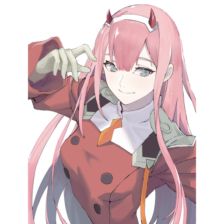

actual tags:
['long_hair', 'simple_background', 'long_sleeves', 'upper_body', 'very_long_hair', 'gloves', 'blue_eyes', 'white_background', 'bangs', 'looking_at_viewer', 'hair_between_eyes', 'smile', 'closed_mouth']


predicted tags with probability above 35%:


,proba
tag,
long_hair,100.0%
bangs,47.6%
smile,47.0%
blush,46.4%
eyebrows_visible_through_hair,46.2%
looking_at_viewer,45.5%
hair_between_eyes,42.7%
simple_background,41.2%
red_eyes,39.9%


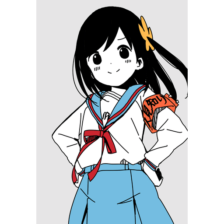

actual tags:
['long_hair', 'standing', 'ribbon', 'school_uniform', 'shirt', 'flower', 'hair_ornament', 'closed_mouth', 'looking_at_viewer', 'simple_background', 'bangs', 'skirt', 'blush', 'smile', 'long_sleeves']


predicted tags with probability above 35%:


,proba
tag,
simple_background,49.8%
bangs,48.2%
smile,46.4%
full_body,45.5%
looking_at_viewer,45.2%
blush,43.8%
long_hair,43.6%
open_mouth,42.9%
eyebrows_visible_through_hair,40.4%


In [22]:
for xb, yb in samp_dl:
    
    show_image(xb.squeeze())
    y_true = proba2lbls(yb.squeeze(), .85).index.to_list()
    y_pred = proba2lbls(model(xb).detach().squeeze(), thresh)
    
    print(f'actual tags:\n{y_true}\n')
    print(f'\npredicted tags with probability above {thresh:.0%}:')
    display(y_pred)
    print('\n==============\n')